Compare a simulation with and without backreaction. You need to run the same setup, only with this difference. You also need to save "data", "bilinears", and "quantum" (this is what the script includes, you can remove something if you prefer). You could also compare "correlators".

In [1]:
using HDF5
using LaTeXStrings
using Plots ; pythonplot()
using DelimitedFiles
using SpheriCo

    CondaPkg Found dependencies: /home/thanasis/.julia/packages/PythonCall/S5MOg/CondaPkg.toml
    CondaPkg Found dependencies: /home/thanasis/.julia/packages/PythonPlot/KcWMF/CondaPkg.toml
    CondaPkg Dependencies already up to date
┌ Warning: backend `PythonPlot` is not installed.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/backends.jl:43


In [2]:
function find_AH_index(r::Vector, B::Vector, A::Vector, KB::Vector)

    hr = r[4] - r[3]
    B_r = Dr_FD2(B, hr)
    Θ = (2.0./r .+ B_r./B)./(A.^0.5) - 2.0.*KB

    test = sign(Θ[end])
    j = length(r)
    while sign(Θ[j])==test && j>=2 # is the 1st ghost point on the left
    test = sign(Θ[j])
    j = j-1
    end

    # we take the midpoint where the sign of the expansion changes. If
    # this is <0, then there is no AH
    rAH_index = j+1
    rAH_index
end

find_AH_index (generic function with 1 method)

In [3]:
# give the directory where the data from all the runs are saved
dir = "../examples/quantum_runs/"
par1 = "a1.25_b0.0_c1.0_rmax30.0_tmax8.0_cfl0.0625_sigma0.02_overMp2_1.0_reg_true_backreact_false_mPV1.0_dk_denom_30_kmax30.0_lmax90.0"
par2 = "a1.25_b0.0_c1.0_rmax30.0_tmax10.0_cfl0.0625_sigma0.02_overMp2_0.9988967160535545_reg_true_backreact_true_rcut20.0_mPV1.0_dk_denom_30_kmax20.0_lmax60.0"
par3 = "a1.25_b0.0_c1.0_rmax30.0_tmax10.0_cfl0.0625_sigma0.02_overMp2_0.9988967160535545_reg_true_backreact_true_rcut20.0_mPV1.0_dk_denom_30_kmax30.0_lmax90.0"

dir1 = dir*par1
dir2 = dir*par2
dir3 = dir*par3

out_dir = "./bh_with_vs_without_backreaction/"*par1*"/"
if ispath(out_dir)==false
    mkpath(out_dir)
end

In [4]:
# number of radial grid points
D = 3
Nr = 128*2^D + 3 # the overal course graining

# load the r grid
r = h5read(dir1*"/data_$(Nr)/r.h5","r")
dr = r[2] - r[1]
# needed later
id = ones(length(r));

# list all available iterations (and corresponding files)
(its, all_filenames) = list_h5_files(dir1*"/data_$(Nr)", prefix="data_");

# list of iterations with saved data for the different data-types
println("length(its)=",length(its))
println("its",its)

length(its)=69
its[0, 64, 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280, 1344, 1408, 1472, 1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984, 2048, 2112, 2176, 2240, 2304, 2368, 2432, 2496, 2560, 2624, 2688, 2752, 2816, 2880, 2944, 3008, 3072, 3136, 3200, 3264, 3328, 3392, 3456, 3520, 3584, 3648, 3712, 3776, 3840, 3904, 3968, 4032, 4096, 4160, 4224, 4288, 4352]


The filter below is used to reconstruct the filter in the backreaction case. Set r_cut and n manually to the values used in the simulation. Needed later.

In [5]:
t_list = zeros(length(its))

r_AH1 = zeros(length(its))
r_AH2 = zeros(length(its))
r_AH3 = zeros(length(its))

A_AH1 = zeros(length(its))
A_AH2 = zeros(length(its))
A_AH3 = zeros(length(its))

M_AH1 = zeros(length(its))
M_AH2 = zeros(length(its))
M_AH3 = zeros(length(its))

for it in 1:length(its)

    it_data = its[it]
    it_str_data  = lpad(it_data, 4, "0")
    
    #v_classic_labels = ["Φ", "Π", "Ψ", "A", "B", "DB", "Utld", "K", "KB", "λ", "α", "Dα", "Θ", "Zr", "f", "g", "U", "V"]
    # dir 1
    v1 = h5read(dir1*"/data_$(Nr)/data_$(it_str_data).h5","v")
    A1 = v1[:,4]
    B1 = v1[:,5]
    KB1 = v1[:,9]
    t1 = h5readattr(dir1*"/data_$(Nr)/data_$(it_str_data).h5", "/")["time"]
    # dir 2
    v2 = h5read(dir2*"/data_$(Nr)/data_$(it_str_data).h5","v")
    A2 = v2[:,4]
    B2 = v2[:,5]
    KB2 = v2[:,9]
    t2 = h5readattr(dir2*"/data_$(Nr)/data_$(it_str_data).h5", "/")["time"]
    # dir 3
    v3 = h5read(dir3*"/data_$(Nr)/data_$(it_str_data).h5","v")
    A3 = v3[:,4]
    B3 = v3[:,5]        
    KB3 = v3[:,9]
    t3 = h5readattr(dir3*"/data_$(Nr)/data_$(it_str_data).h5", "/")["time"]
    
    # checks if time instant is the same for all types of data
    @assert t1 ≈ t2 ≈ t3
    t_list[it] = t1

    ri_AH1 = find_AH_index(r, B1, A1, KB1)
    ri_AH2 = find_AH_index(r, B2, A2, KB2)
    ri_AH3 = find_AH_index(r, B3, A3, KB3)
    r_AH1[it] = r[ri_AH1]
    r_AH2[it] = r[ri_AH2]
    r_AH3[it] = r[ri_AH3]
    
    A_AH1[it] = 4*π*B1[ri_AH1]*r_AH1[it]^2
    A_AH2[it] = 4*π*B2[ri_AH2]*r_AH2[it]^2
    A_AH3[it] = 4*π*B3[ri_AH3]*r_AH3[it]^2

    M_AH1[it] = r_AH1[it]*sqrt(B1[ri_AH1])/2
    M_AH2[it] = r_AH2[it]*sqrt(B2[ri_AH1])/2
    M_AH3[it] = r_AH3[it]*sqrt(B3[ri_AH1])/2

end

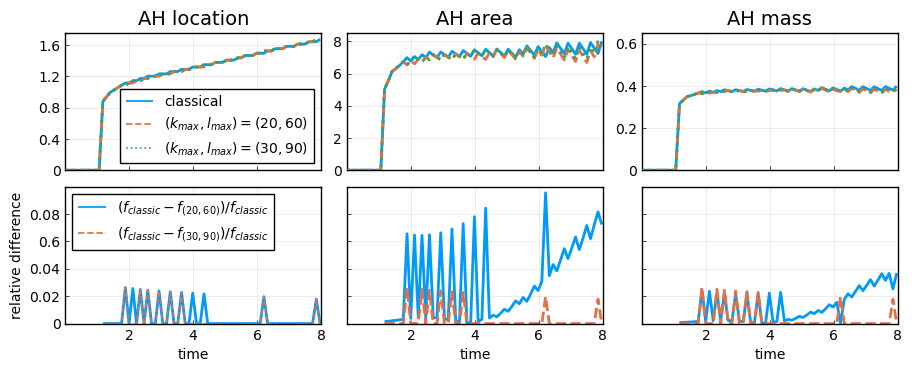

"/home/thanasis/repos/SpheriCo.jl/tools/bh_with_vs_without_backreaction/a1.25_b0.0_c1.0_rmax30.0_tmax8.0_cfl0.0625_sigma0.02_overMp2_1.0_reg_true_backreact_false_mPV1.0_dk_denom_30_kmax30.0_lmax90.0/AH_location_area_mass.pdf"

In [12]:
#  AH location
plot(t_list, r_AH1, title = "AH location",
     label = "classical", linewidth = 2, frame = true, wsize = (800,400), legend=:bottomright)
plot!(t_list, r_AH2, label = L"(k_{max},l_{max})=(20,60)", linewidth = 2, style=:dash)
p1 = plot!(t_list, r_AH3,label = L"(k_{max},l_{max})=(30,90)", linewidth = 2, style=:dot,
     xlim=(0,8),
     ylim=(0,1.75),
     yticks = ([0,0.4,0.8,1.2,1.6],["0","0.4","0.8","1.2","1.6"]),
     #xticks=([0,2,4,6,8],["","2","4","6","8"]),
     xticks=([0,2,4,6,8],["","","","",""]),
     legendfontsize=10,
     xtickfont=10, xguidefontsize=10,
     ytickfont=10, yguidefontsize=10,
     #xlabel="time",
    xlabel="",
)

#############################################
# AH area

plot(t_list, A_AH1, title = "AH area",
     label = "", linewidth = 2, frame = true, wsize = (800,400), legend=:false)
plot!(t_list, A_AH2, label = "", linewidth = 2,style=:dash)
p2 = plot!(t_list, A_AH3,label = "", linewidth = 2, style=:dot,
     xlim=(0,8),
     ylim=(0,8.5),
     yticks = ([0,2,4,6,8],["0","2","4","6","8"]),
     #xticks=([0,2,4,6,8],["","2","4","6","8"]),
     xticks=([0,2,4,6,8],["","","","",""]),
     legendfontsize=10,
     xtickfont=10, xguidefontsize=10,
     ytickfont=10, yguidefontsize=10,
     #xlabel="time",
     xlabel=""
)

##########################################
# AH mass

plot(t_list, M_AH1, title = "AH mass",
     label = "", linewidth = 2, frame = true, wsize = (800,400), legend=:false)
plot!(t_list, M_AH2, label = "", linewidth = 2, style=:dash)
p3 = plot!(t_list, M_AH3,label = "", linewidth = 2, style=:dot,
     xlim=(0,8),
     ylim=(0,0.65),
     yticks = ([0,0.2,0.4,0.6],["0","0.2","0.4","0.6"]),
     #xticks=([0,2,4,6,8],["","2","4","6","8"]),
     xticks=([0,2,4,6,8],["","","","",""]),
     legendfontsize=10,
     xtickfont=10, xguidefontsize=10,
     ytickfont=10, yguidefontsize=10,
     #xlabel="time",
     xlabel=""
)

#############################################
#  AH location relative difference
plot(t_list, abs.(r_AH2.-r_AH1)./r_AH1, 
     #label = L"\frac{r^{AH}_{cl}-r^{AH}_{(20,60)}}{r^{AH}_{cl}}", 
    label = L"(f_{classic}-f_{(20,60)})/f_{classic}", 
    linewidth = 2, frame = true, wsize = (800,400), legend=:topleft)
p4 = plot!(t_list, abs.(r_AH3.-r_AH1)./r_AH1, 
     #label = L"\frac{r^{AH}_{cl}-r^{AH}_{(30,90)}}{r^{AH}_{cl}}",
    label = L"(f_{classic}-f_{(30,90)})/f_{classic}",
    inewidth = 2.2, style=:dash,
     xlim=(0,8),
     ylim=(0,0.1),
     yticks = ([0,0.02,0.04,0.06,0.08],["0","0.02","0.04","0.6","0.08"]),
     xticks=([0,2,4,6,8],["","2","4","6","8"]),
     legendfontsize=10,
     xtickfont=10, xguidefontsize=10,
     ytickfont=10, yguidefontsize=10,
     xlabel="time",
     ylabel = "relative difference"
)

#############################################
#  AH area relative difference
plot(t_list, abs.(A_AH2.-A_AH1)./A_AH1, 
     #label = L"\frac{A^{AH}_{cl}-A^{AH}_{(20,60)}}{A^{AH}_{cl}}",
    label="",
    linewidth = 2, frame = true, wsize = (800,400), legend=:topleft)
p5 = plot!(t_list, abs.(r_AH3.-r_AH1)./r_AH1, 
    # label = L"\frac{A^{AH}_{cl}-A^{AH}_{(30,90)}}{A^{AH}_{cl}}", 
    label="",
    linewidth = 2, style=:dash,
     xlim=(0,8),
     ylim=(0,0.1),
     yticks = ([0,0.02,0.04,0.06,0.08],["","","","",""]),
     xticks=([0,2,4,6,8],["","2","4","6","8"]),
     legendfontsize=10,
     xtickfont=10, xguidefontsize=10,
     ytickfont=10, yguidefontsize=10,
     xlabel="time",
     ylabel = ""
)

#############################################
#  AH mass relative difference
plot(t_list, abs.(M_AH2.-M_AH1)./M_AH1, 
     #label = L"\frac{M^{BH}_{cl}-M^{AH}_{(20,60)}}{M^{BH}_{cl}}",
    label="",
    linewidth = 2, frame = true, wsize = (800,400), legend=:topleft)
p6 = plot!(t_list, abs.(r_AH3.-r_AH1)./r_AH1, 
     #label = L"\frac{M^{BH}_{cl}-M^{BH}_{(30,90)}}{M^{BH}_{cl}}",
    label="",
    linewidth = 2, style=:dash,
     xlim=(0,8),
     ylim=(0,0.1),
     yticks = ([0,0.02,0.04,0.06,0.08],["","","","",""]),
     xticks=([0,2,4,6,8],["","2","4","6","8"]),
     legendfontsize=10,
     xtickfont=10, xguidefontsize=10,
     ytickfont=10, yguidefontsize=10,
     xlabel="time",
     ylabel = ""
)

plt = plot(p1, p2, p3, p4, p5, p6,
    layout = grid(2,3), wsize = (900,2*180))

savefig(plt, out_dir*"/AH_location_area_mass.pdf")


In [7]:
function calc_crlt_AH(dir, it, crlt_i)

    (its, all_filenames)           = list_h5_files(dir*"/data_$(Nr)", prefix="data_");
    (its_crlt, all_filenames_crlt) = list_h5_files(dir*"/data_$(Nr)", prefix="correlators_");
    
    # if you have not saved data and correlators on the same timesteps
    # you need to change it below, accordingly
    it_data = its[it]
    it_str_data  = lpad(it_data, 4, "0")
    
    it_crlt = its_crlt[it]
    it_str_crlt  = lpad(it_crlt, 4, "0")
    
    v = h5read(dir*"/data_$(Nr)/data_$(it_str_data).h5","v")
    A  = v[:,4]
    B  = v[:,5]
    KB = v[:,9]
    
    crlt = h5read(dir*"/data_$(Nr)/correlators_$(it_str_crlt).h5","correlators")
    
    # if there is an error when loading the time attribute, try to change "./" to "." or to "/" 
    t_data   =  h5readattr(dir*"/data_$(Nr)/data_$(it_str_data).h5", "/")["time"]
    t_crlt   =  h5readattr(dir*"/data_$(Nr)/correlators_$(it_str_crlt).h5", "/")["time"]
    AH = find_AH(r, B, A, KB)

    # checks if time instant is the same for all types of data
    @assert t_data ≈ t_crlt

    return AH, real(crlt[:,:,crlt_i]), t_data
end


calc_crlt_AH (generic function with 1 method)

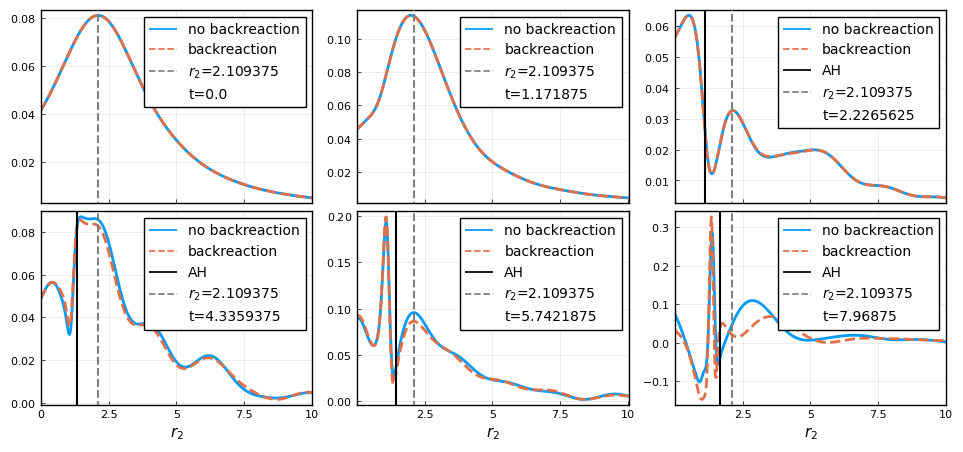

"/home/thanasis/repos/SpheriCo.jl/tools/bh_with_vs_without_backreaction/a1.25_b0.0_c1.0_rmax30.0_tmax8.0_cfl0.0625_sigma0.02_overMp2_1.0_reg_true_backreact_false_mPV1.0_dk_denom_30_kmax30.0_lmax90.0/crlts.pdf"

In [8]:
ri_min = 3
ri_max = 345
ri = 75 # r slice
clr_s = "grey"
ls = 10
clr_ah = "black"

# which correlator you want (see previous cell for the structure). There are 5 different (1-5).
crlt_i =3 

##########################################################
it = 1

AH1, crlt1, t = calc_crlt_AH(dir1, it, crlt_i);
AH3, crlt3, t = calc_crlt_AH(dir3, it, crlt_i);

plot(r[ri_min:ri_max],  crlt1[ri_min:ri_max, ri], label="no backreaction", frame = true, linewidth=2)
plot!(r[ri_min:ri_max],  crlt3[ri_min:ri_max, ri], label="backreaction", linewidth=2, style=:dash,
         xlim = (0,r[ri_max]),
    #ylim=(0,0.12),
    #yticks=([0,0.04,0.08,0.12],["0","0.04","0.08","0.12"]),
    xticks=([0,2.5,5,7.5,10],["","","","",""])

)

p1 = plot!([r[ri]], seriestype="vline", label=L"r_2"*"=$(r[ri])", linewidth=1.5, color = clr_s, legendfontsize=ls, style=:dash)
p1 = plot!([-1], seriestype="vline", label="t=$(t)", linewidth=1.5, color = "white", legendfontsize=ls, style=:dash)

##########################################################
it = 11

AH1, crlt1, t = calc_crlt_AH(dir1, it, crlt_i);
AH3, crlt3, t = calc_crlt_AH(dir3, it, crlt_i);

plot(r[ri_min:ri_max],  crlt1[ri_min:ri_max, ri], label="no backreaction", frame = true, linewidth=2)
plot!(r[ri_min:ri_max],  crlt3[ri_min:ri_max, ri], label="backreaction", linewidth=2, style=:dash,
         xlim = (0,r[ri_max]),
#ylim=(0,0.12),
    #yticks=([0,0.04,0.08,0.12],["","","",""]),
    xticks=([0,2.5,5,7.5,10],["","","","",""])

)

p2 = plot!([r[ri]], seriestype="vline", label=L"r_2"*"=$(r[ri])", linewidth=1.5, color = clr_s, legendfontsize=ls, style=:dash)
p2 = plot!([-1], seriestype="vline", label="t=$(t)", linewidth=1.5, color = "white", legendfontsize=ls, style=:dash)

##########################################################
it = 20

AH, crlt1, t = calc_crlt_AH(dir1, it, crlt_i);
AH3, crlt3, t = calc_crlt_AH(dir3, it, crlt_i);

plot(r[ri_min:ri_max],  crlt1[ri_min:ri_max, ri], label="no backreaction", frame = true, linewidth=2)
plot!(r[ri_min:ri_max],  crlt3[ri_min:ri_max, ri], label="backreaction", linewidth=2, style=:dash,
         xlim = (0,r[ri_max]),
    #ylim=(0,0.12),
    #yticks=([0,0.04,0.08,0.12],["","","",""]),
    xticks=([0,2.5,5,7.5,10],["","","","",""])

)

plot!([AH], seriestype="vline", label="AH", linewidth=1.5, color = clr_ah, legendfontsize=ls)
p3 = plot!([r[ri]], seriestype="vline", label=L"r_2"*"=$(r[ri])", linewidth=1.5, color = clr_s, legendfontsize=ls, style=:dash)
p3 = plot!([-1], seriestype="vline", label="t=$(t)", linewidth=1.5, color = "white", legendfontsize=ls, style=:dash)

##########################################################
it = 38

AH, crlt1, t = calc_crlt_AH(dir1, it, crlt_i);
AH3, crlt3, t = calc_crlt_AH(dir3, it, crlt_i);

plot(r[ri_min:ri_max],  crlt1[ri_min:ri_max, ri], label="no backreaction", frame = true, linewidth=2)
plot!(r[ri_min:ri_max],  crlt3[ri_min:ri_max, ri], label="backreaction", linewidth=2, style=:dash,
         xlim = (0,r[ri_max]),
    #yticks=([0.02,0.04,0.06,0.08],["0.02","0.04","0.06","0.08"]),
    xticks=([0,2.5,5,7.5,10],["0","2.5","5","7.5","10"]),
    xlabel=L"r_2",

)

plot!([AH], seriestype="vline", label="AH", linewidth=1.5, color = clr_ah, legendfontsize=ls)
p4 = plot!([r[ri]], seriestype="vline", label=L"r_2"*"=$(r[ri])", linewidth=1.5, color = clr_s, legendfontsize=ls, style=:dash)
p4 = plot!([-1], seriestype="vline", label="t=$(t)", linewidth=1.5, color = "white", legendfontsize=ls, style=:dash)

##########################################################
it = 50

AH, crlt1, t = calc_crlt_AH(dir1, it, crlt_i);
AH3, crlt3, t = calc_crlt_AH(dir3, it, crlt_i);

plot(r[ri_min:ri_max],  crlt1[ri_min:ri_max, ri], label="no backreaction", frame = true, linewidth=2)
plot!(r[ri_min:ri_max],  crlt3[ri_min:ri_max, ri], label="backreaction", linewidth=2, style=:dash,
         xlim = (0,r[ri_max]),
    #yticks=([0.02,0.04,0.06,0.08],["0.02","0.04","0.06","0.08"]),
    xticks=([0,2.5,5,7.5,10],["","2.5","5","7.5","10"]),
    xlabel=L"r_2",

)
plot!([AH], seriestype="vline", label="AH", linewidth=1.5, color = clr_ah, legendfontsize=ls)
p5 = plot!([r[ri]], seriestype="vline", label=L"r_2"*"=$(r[ri])", linewidth=1.5, color = clr_s, legendfontsize=ls, style=:dash)
p5 = plot!([-1], seriestype="vline", label="t=$(t)", linewidth=1.5, color = "white", legendfontsize=ls, style=:dash)

##########################################################
it = 69

AH, crlt1, t = calc_crlt_AH(dir1, it, crlt_i);
AH3, crlt3, t = calc_crlt_AH(dir3, it, crlt_i);

plot(r[ri_min:ri_max],  crlt1[ri_min:ri_max, ri], label="no backreaction", frame = true, linewidth=2)
plot!(r[ri_min:ri_max],  crlt3[ri_min:ri_max, ri], label="backreaction", linewidth=2, style=:dash,
         xlim = (0,r[ri_max]),
    #yticks=([0.02,0.04,0.06,0.08],["0.02","0.04","0.06","0.08"]),
    xticks=([0,2.5,5,7.5,10],["","2.5","5","7.5","10"]),
    xlabel=L"r_2",

)

plot!([AH], seriestype="vline", label="AH", linewidth=1.5, color = clr_ah, legendfontsize=ls)
p6 = plot!([r[ri]], seriestype="vline", label=L"r_2"*"=$(r[ri])", linewidth=1.5, color = clr_s, legendfontsize=ls, style=:dash)
p6 = plot!([-1], seriestype="vline", label="t=$(t)", linewidth=1.5, color = "white", legendfontsize=ls, style=:dash)

##########################################################
plt = plot(p1, p2, p3, p4, p5, p6,
    layout = grid(2,3), wsize = (950,2*220))

savefig(plt, out_dir*"/crlts.pdf")